In [1]:
import stable_baselines3
import gym
import numpy as np

# Environement
import gym
from gym import spaces

# Evaluate the environement
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.results_plotter import load_results, ts2xy, plot_results
from stable_baselines3.common.monitor import Monitor

# Agent
from stable_baselines3 import A2C,PPO

# Policy
from stable_baselines3.ppo import MlpPolicy, CnnPolicy
from stable_baselines3.common.policies import ActorCriticPolicy

import matplotlib.pyplot as plt
import os

In [2]:
log_dir = "bf/a2c/mlp/"
os.makedirs(log_dir, exist_ok=False)

FileExistsError: [Errno 17] File exists: 'bf/a2c/mlp/'

# Environement

## Definition

In [12]:
class CustomEnv(gym.Env):
    """Custom Environment that follows gym interface"""
    metadata = {'render.modes': ['human']}

    CASE_VIDE = 255
    
    def __init__(self, grid_size=(10,10),nspecies=5):
        # CONTROLES DONNEES
        assert nspecies < 256-1 # pour compatibilité avec uint8. 0 est pris par l'information case vide
        
        # INITILISATIION SUBCLASS
        super().__init__()
        
        
        # PARAMETRES 
        self.grid_size = grid_size
        self.nspecies = nspecies

        
        # Define action space
        # ESSAI 1 : NE MARCHE PAS, CE SONT DES VALEURS CONTINUES MEME AVEC dype
#         self.action_space = spaces.Box(low=np.array([0,0,0]),
#                                       high=np.array(self.grid_size + (self.nspecies,)),
#                                       shape=(3,),
#                                       dtype=np.uint8)        
        
        # ESSAI 2 :
        self.action_space =spaces.MultiDiscrete(self.grid_size + (self.nspecies,))
        
        # Define observation space
        self.observation_space = spaces.Box(low=0,
                                            high=self.nspecies,
                                            shape=grid_size, dtype=np.uint8)
        
        self.state = np.full(self.grid_size,self.CASE_VIDE)
    
    
    def step(self, action):
        # ACTION -> ACTION LOCALE
        x,y,specie = action
        
        # CONTROLE
        assert specie != self.CASE_VIDE
        
        done = False # JUSQU'A PREUVE DU CONTRAIRE LA PARTIE CONTINUE
        info = {} # UTILISE POUR DEBUGAGE
        reward = 0
        if self.state[x,y]==self.CASE_VIDE:
            # ACTION VALIDE (CASE LIBRE) CAR ==0            
            self.state[x,y] = specie # ON PLANTE
            reward = 1 # <--------------------------------------------------REWARD NON LEGUME
            if (self.state[x,y]!=self.CASE_VIDE).sum()==0:
                # DANS LE CAS ON IL N'Y A PLUS DE CASES VIDES
                reward = 100 # <--------------------------------------------------REWARD SUCCESS
                done = True 
            
        else:
            # ACTION NON VALIDE CASE DEJA REMPLIE
            reward = -100 # <--------------------------------------------------REWARD FAIL
            done = True
            
        return self.to_observation(), reward, done, info
    
    def reset(self):
        self.state = np.full(self.grid_size,self.CASE_VIDE)
        # TODO ESSAYER DE FAIRE UN RANDOM A CHAQUE RESET PLUTOT 0, COMME SUGGERE PAR GUILLAUME
        return self.to_observation()
    
    def to_observation(self):
        return self.state.copy()
    
    def render(self,mode="human"):
        return self.to_observation()
        


## Instanciation

In [13]:
env = CustomEnv()
eval_env = CustomEnv(nspecies=1) # Use a separate environement for evaluation
env = Monitor(env, log_dir)

# Agent

In [14]:
algo_with_policy = A2C('MlpPolicy', env, verbose=2)

Using cpu device
Wrapping the env in a DummyVecEnv.


## Evaluate initial Agent

In [15]:
# Random Agent, before training
mean_reward, std_reward = evaluate_policy(algo_with_policy, eval_env, n_eval_episodes=100)
print(f"mean_reward:{mean_reward:.2f} +/- {std_reward:.2f}")

mean_reward:-99.00 +/- 0.00


## Train the agent

In [16]:
class MyCallBack(BaseCallback):
    def __init__(self,log_dir,steps_to_print,verbose=0):
        super().__init__()
        self.log_dir = log_dir
        self.steps_to_print = steps_to_print
        
    def _on_step(self) -> bool:
        if self.num_timesteps % self.steps_to_print == 0:
            plt.imshow(self.locals["obs_tensor"].numpy()[0,:,:])
            plt.show()


-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 10.7      |
|    ep_rew_mean        | -90.3     |
| time/                 |           |
|    fps                | 2055      |
|    iterations         | 100       |
|    time_elapsed       | 0         |
|    total_timesteps    | 500       |
| train/                |           |
|    entropy_loss       | -5.48     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0007    |
|    n_updates          | 4000099   |
|    policy_loss        | -784      |
|    value_loss         | 3.07e+04  |
-------------------------------------


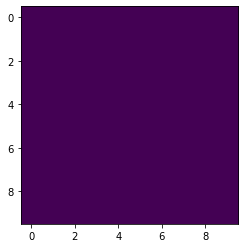

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 11.9     |
|    ep_rew_mean        | -89.1    |
| time/                 |          |
|    fps                | 2022     |
|    iterations         | 200      |
|    time_elapsed       | 0        |
|    total_timesteps    | 1000     |
| train/                |          |
|    entropy_loss       | -5.61    |
|    explained_variance | 0        |
|    learning_rate      | 0.0007   |
|    n_updates          | 4000199  |
|    policy_loss        | 0.184    |
|    value_loss         | 0.00109  |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 12.4     |
|    ep_rew_mean        | -88.5    |
| time/                 |          |
|    fps                | 2029     |
|    iterations         | 300      |
|    time_elapsed       | 0        |
|    total_timesteps    | 1500     |
| train/                |          |
|

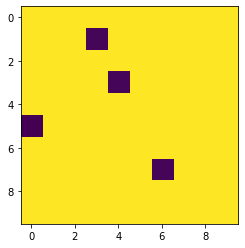

-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 12        |
|    ep_rew_mean        | -89       |
| time/                 |           |
|    fps                | 1946      |
|    iterations         | 400       |
|    time_elapsed       | 1         |
|    total_timesteps    | 2000      |
| train/                |           |
|    entropy_loss       | -6.02     |
|    explained_variance | 1.19e-07  |
|    learning_rate      | 0.0007    |
|    n_updates          | 4000399   |
|    policy_loss        | -1.17e+03 |
|    value_loss         | 3.8e+04   |
-------------------------------------
-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 11.5      |
|    ep_rew_mean        | -89.5     |
| time/                 |           |
|    fps                | 1966      |
|    iterations         | 500       |
|    time_elapsed       | 1         |
|    total_timesteps    | 2500      |
| train/    

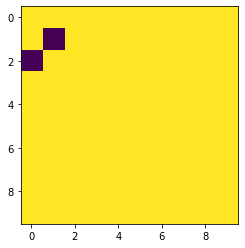

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 12.3     |
|    ep_rew_mean        | -88.7    |
| time/                 |          |
|    fps                | 1740     |
|    iterations         | 600      |
|    time_elapsed       | 1        |
|    total_timesteps    | 3000     |
| train/                |          |
|    entropy_loss       | -5.88    |
|    explained_variance | 0        |
|    learning_rate      | 0.0007   |
|    n_updates          | 4000599  |
|    policy_loss        | 0.165    |
|    value_loss         | 0.0011   |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 12.9     |
|    ep_rew_mean        | -88.1    |
| time/                 |          |
|    fps                | 1789     |
|    iterations         | 700      |
|    time_elapsed       | 1        |
|    total_timesteps    | 3500     |
| train/                |          |
|

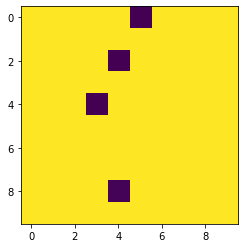

-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 12.8      |
|    ep_rew_mean        | -88.2     |
| time/                 |           |
|    fps                | 1823      |
|    iterations         | 800       |
|    time_elapsed       | 2         |
|    total_timesteps    | 4000      |
| train/                |           |
|    entropy_loss       | -5.57     |
|    explained_variance | 0         |
|    learning_rate      | 0.0007    |
|    n_updates          | 4000799   |
|    policy_loss        | -1.04e+03 |
|    value_loss         | 3.8e+04   |
-------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 11.9     |
|    ep_rew_mean        | -89.1    |
| time/                 |          |
|    fps                | 1768     |
|    iterations         | 900      |
|    time_elapsed       | 2        |
|    total_timesteps    | 4500     |
| train/             

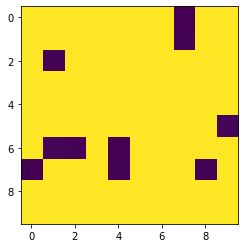

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 11.3     |
|    ep_rew_mean        | -89.7    |
| time/                 |          |
|    fps                | 1756     |
|    iterations         | 1000     |
|    time_elapsed       | 2        |
|    total_timesteps    | 5000     |
| train/                |          |
|    entropy_loss       | -5.94    |
|    explained_variance | 5.96e-08 |
|    learning_rate      | 0.0007   |
|    n_updates          | 4000999  |
|    policy_loss        | 0.261    |
|    value_loss         | 0.00199  |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 11.6     |
|    ep_rew_mean        | -89.4    |
| time/                 |          |
|    fps                | 1780     |
|    iterations         | 1100     |
|    time_elapsed       | 3        |
|    total_timesteps    | 5500     |
| train/                |          |
|

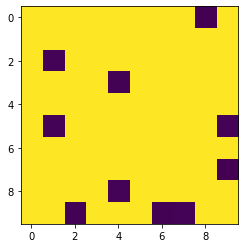

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 12.4     |
|    ep_rew_mean        | -88.6    |
| time/                 |          |
|    fps                | 1802     |
|    iterations         | 1200     |
|    time_elapsed       | 3        |
|    total_timesteps    | 6000     |
| train/                |          |
|    entropy_loss       | -5.78    |
|    explained_variance | 0        |
|    learning_rate      | 0.0007   |
|    n_updates          | 4001199  |
|    policy_loss        | 0.188    |
|    value_loss         | 0.00143  |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 11.6     |
|    ep_rew_mean        | -89.4    |
| time/                 |          |
|    fps                | 1830     |
|    iterations         | 1300     |
|    time_elapsed       | 3        |
|    total_timesteps    | 6500     |
| train/                |          |
|

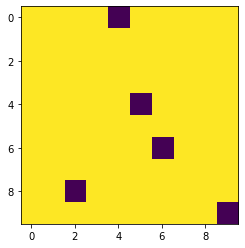

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 10.5     |
|    ep_rew_mean        | -90.5    |
| time/                 |          |
|    fps                | 1846     |
|    iterations         | 1400     |
|    time_elapsed       | 3        |
|    total_timesteps    | 7000     |
| train/                |          |
|    entropy_loss       | -4.64    |
|    explained_variance | 5.96e-08 |
|    learning_rate      | 0.0007   |
|    n_updates          | 4001399  |
|    policy_loss        | -627     |
|    value_loss         | 3.13e+04 |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 10.4     |
|    ep_rew_mean        | -90.6    |
| time/                 |          |
|    fps                | 1856     |
|    iterations         | 1500     |
|    time_elapsed       | 4        |
|    total_timesteps    | 7500     |
| train/                |          |
|

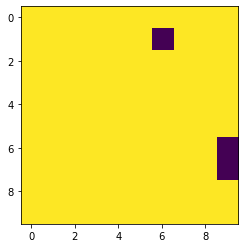

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 10.8     |
|    ep_rew_mean        | -90.2    |
| time/                 |          |
|    fps                | 1850     |
|    iterations         | 1600     |
|    time_elapsed       | 4        |
|    total_timesteps    | 8000     |
| train/                |          |
|    entropy_loss       | -5.57    |
|    explained_variance | 0        |
|    learning_rate      | 0.0007   |
|    n_updates          | 4001599  |
|    policy_loss        | 0.216    |
|    value_loss         | 0.00198  |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 11.4     |
|    ep_rew_mean        | -89.6    |
| time/                 |          |
|    fps                | 1860     |
|    iterations         | 1700     |
|    time_elapsed       | 4        |
|    total_timesteps    | 8500     |
| train/                |          |
|

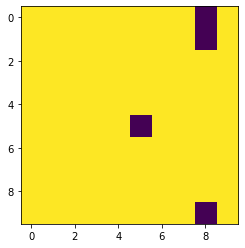

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 12.1     |
|    ep_rew_mean        | -88.9    |
| time/                 |          |
|    fps                | 1870     |
|    iterations         | 1800     |
|    time_elapsed       | 4        |
|    total_timesteps    | 9000     |
| train/                |          |
|    entropy_loss       | -5.36    |
|    explained_variance | 0        |
|    learning_rate      | 0.0007   |
|    n_updates          | 4001799  |
|    policy_loss        | -1.1e+03 |
|    value_loss         | 3.8e+04  |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 12.6     |
|    ep_rew_mean        | -88.4    |
| time/                 |          |
|    fps                | 1885     |
|    iterations         | 1900     |
|    time_elapsed       | 5        |
|    total_timesteps    | 9500     |
| train/                |          |
|

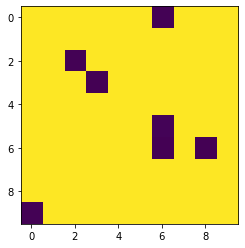

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 13.3     |
|    ep_rew_mean        | -87.7    |
| time/                 |          |
|    fps                | 1879     |
|    iterations         | 2000     |
|    time_elapsed       | 5        |
|    total_timesteps    | 10000    |
| train/                |          |
|    entropy_loss       | -5.72    |
|    explained_variance | 0        |
|    learning_rate      | 0.0007   |
|    n_updates          | 4001999  |
|    policy_loss        | -533     |
|    value_loss         | 1.57e+04 |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 13.3     |
|    ep_rew_mean        | -87.7    |
| time/                 |          |
|    fps                | 1879     |
|    iterations         | 2100     |
|    time_elapsed       | 5        |
|    total_timesteps    | 10500    |
| train/                |          |
|

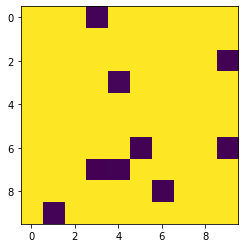

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 12.2     |
|    ep_rew_mean        | -88.8    |
| time/                 |          |
|    fps                | 1888     |
|    iterations         | 2200     |
|    time_elapsed       | 5        |
|    total_timesteps    | 11000    |
| train/                |          |
|    entropy_loss       | -5.8     |
|    explained_variance | 0        |
|    learning_rate      | 0.0007   |
|    n_updates          | 4002199  |
|    policy_loss        | 0.252    |
|    value_loss         | 0.00215  |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 12.3     |
|    ep_rew_mean        | -88.7    |
| time/                 |          |
|    fps                | 1901     |
|    iterations         | 2300     |
|    time_elapsed       | 6        |
|    total_timesteps    | 11500    |
| train/                |          |
|

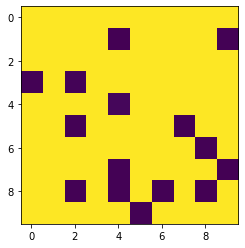

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 12.6     |
|    ep_rew_mean        | -88.5    |
| time/                 |          |
|    fps                | 1907     |
|    iterations         | 2400     |
|    time_elapsed       | 6        |
|    total_timesteps    | 12000    |
| train/                |          |
|    entropy_loss       | -5.83    |
|    explained_variance | 0        |
|    learning_rate      | 0.0007   |
|    n_updates          | 4002399  |
|    policy_loss        | 0.202    |
|    value_loss         | 0.0015   |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 12.2     |
|    ep_rew_mean        | -88.8    |
| time/                 |          |
|    fps                | 1915     |
|    iterations         | 2500     |
|    time_elapsed       | 6        |
|    total_timesteps    | 12500    |
| train/                |          |
|

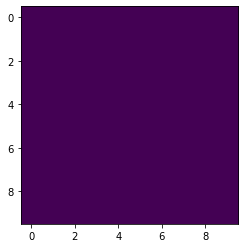

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 11.7     |
|    ep_rew_mean        | -89.3    |
| time/                 |          |
|    fps                | 1919     |
|    iterations         | 2600     |
|    time_elapsed       | 6        |
|    total_timesteps    | 13000    |
| train/                |          |
|    entropy_loss       | -5.43    |
|    explained_variance | 0        |
|    learning_rate      | 0.0007   |
|    n_updates          | 4002599  |
|    policy_loss        | -212     |
|    value_loss         | 7.9e+03  |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 12       |
|    ep_rew_mean        | -89      |
| time/                 |          |
|    fps                | 1929     |
|    iterations         | 2700     |
|    time_elapsed       | 6        |
|    total_timesteps    | 13500    |
| train/                |          |
|

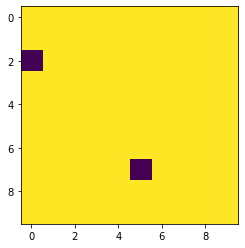

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 12.3     |
|    ep_rew_mean        | -88.7    |
| time/                 |          |
|    fps                | 1935     |
|    iterations         | 2800     |
|    time_elapsed       | 7        |
|    total_timesteps    | 14000    |
| train/                |          |
|    entropy_loss       | -5.35    |
|    explained_variance | 0        |
|    learning_rate      | 0.0007   |
|    n_updates          | 4002799  |
|    policy_loss        | -469     |
|    value_loss         | 1.57e+04 |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 12.9     |
|    ep_rew_mean        | -88.1    |
| time/                 |          |
|    fps                | 1944     |
|    iterations         | 2900     |
|    time_elapsed       | 7        |
|    total_timesteps    | 14500    |
| train/                |          |
|

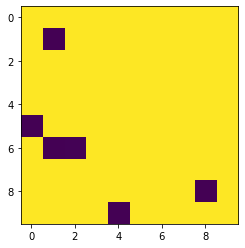

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 13       |
|    ep_rew_mean        | -88      |
| time/                 |          |
|    fps                | 1948     |
|    iterations         | 3000     |
|    time_elapsed       | 7        |
|    total_timesteps    | 15000    |
| train/                |          |
|    entropy_loss       | -5.15    |
|    explained_variance | 0        |
|    learning_rate      | 0.0007   |
|    n_updates          | 4002999  |
|    policy_loss        | -733     |
|    value_loss         | 2.33e+04 |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 11.6     |
|    ep_rew_mean        | -89.5    |
| time/                 |          |
|    fps                | 1956     |
|    iterations         | 3100     |
|    time_elapsed       | 7        |
|    total_timesteps    | 15500    |
| train/                |          |
|

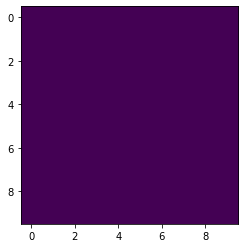

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 12       |
|    ep_rew_mean        | -89      |
| time/                 |          |
|    fps                | 1953     |
|    iterations         | 3200     |
|    time_elapsed       | 8        |
|    total_timesteps    | 16000    |
| train/                |          |
|    entropy_loss       | -4.71    |
|    explained_variance | 1.19e-07 |
|    learning_rate      | 0.0007   |
|    n_updates          | 4003199  |
|    policy_loss        | 0.152    |
|    value_loss         | 0.00138  |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 11.8     |
|    ep_rew_mean        | -89.2    |
| time/                 |          |
|    fps                | 1956     |
|    iterations         | 3300     |
|    time_elapsed       | 8        |
|    total_timesteps    | 16500    |
| train/                |          |
|

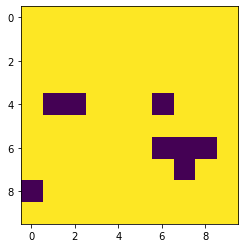

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 11.8     |
|    ep_rew_mean        | -89.2    |
| time/                 |          |
|    fps                | 1960     |
|    iterations         | 3400     |
|    time_elapsed       | 8        |
|    total_timesteps    | 17000    |
| train/                |          |
|    entropy_loss       | -4.61    |
|    explained_variance | 5.96e-08 |
|    learning_rate      | 0.0007   |
|    n_updates          | 4003399  |
|    policy_loss        | -150     |
|    value_loss         | 7.91e+03 |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 11.8     |
|    ep_rew_mean        | -89.2    |
| time/                 |          |
|    fps                | 1966     |
|    iterations         | 3500     |
|    time_elapsed       | 8        |
|    total_timesteps    | 17500    |
| train/                |          |
|

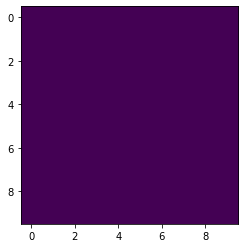

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 11.9     |
|    ep_rew_mean        | -89.1    |
| time/                 |          |
|    fps                | 1969     |
|    iterations         | 3600     |
|    time_elapsed       | 9        |
|    total_timesteps    | 18000    |
| train/                |          |
|    entropy_loss       | -5.33    |
|    explained_variance | 1.19e-07 |
|    learning_rate      | 0.0007   |
|    n_updates          | 4003599  |
|    policy_loss        | 0.172    |
|    value_loss         | 0.00143  |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 12.3     |
|    ep_rew_mean        | -88.7    |
| time/                 |          |
|    fps                | 1970     |
|    iterations         | 3700     |
|    time_elapsed       | 9        |
|    total_timesteps    | 18500    |
| train/                |          |
|

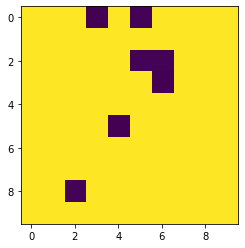

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 12       |
|    ep_rew_mean        | -89      |
| time/                 |          |
|    fps                | 1973     |
|    iterations         | 3800     |
|    time_elapsed       | 9        |
|    total_timesteps    | 19000    |
| train/                |          |
|    entropy_loss       | -5.55    |
|    explained_variance | 1.19e-07 |
|    learning_rate      | 0.0007   |
|    n_updates          | 4003799  |
|    policy_loss        | -445     |
|    value_loss         | 1.56e+04 |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 11.4     |
|    ep_rew_mean        | -89.6    |
| time/                 |          |
|    fps                | 1976     |
|    iterations         | 3900     |
|    time_elapsed       | 9        |
|    total_timesteps    | 19500    |
| train/                |          |
|

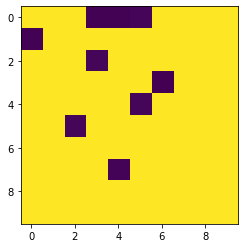

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 11.8     |
|    ep_rew_mean        | -89.2    |
| time/                 |          |
|    fps                | 1979     |
|    iterations         | 4000     |
|    time_elapsed       | 10       |
|    total_timesteps    | 20000    |
| train/                |          |
|    entropy_loss       | -5.75    |
|    explained_variance | 0        |
|    learning_rate      | 0.0007   |
|    n_updates          | 4003999  |
|    policy_loss        | 0.242    |
|    value_loss         | 0.00188  |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 12.9     |
|    ep_rew_mean        | -88      |
| time/                 |          |
|    fps                | 1985     |
|    iterations         | 4100     |
|    time_elapsed       | 10       |
|    total_timesteps    | 20500    |
| train/                |          |
|

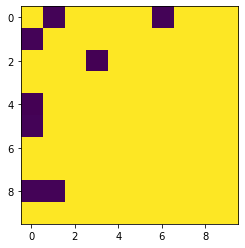

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 13       |
|    ep_rew_mean        | -88      |
| time/                 |          |
|    fps                | 1987     |
|    iterations         | 4200     |
|    time_elapsed       | 10       |
|    total_timesteps    | 21000    |
| train/                |          |
|    entropy_loss       | -5.24    |
|    explained_variance | 0        |
|    learning_rate      | 0.0007   |
|    n_updates          | 4004199  |
|    policy_loss        | -254     |
|    value_loss         | 7.93e+03 |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 12.8     |
|    ep_rew_mean        | -88.2    |
| time/                 |          |
|    fps                | 1992     |
|    iterations         | 4300     |
|    time_elapsed       | 10       |
|    total_timesteps    | 21500    |
| train/                |          |
|

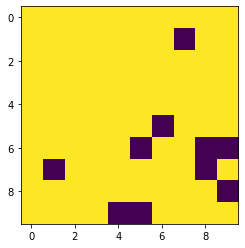

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 12.8     |
|    ep_rew_mean        | -88.2    |
| time/                 |          |
|    fps                | 1994     |
|    iterations         | 4400     |
|    time_elapsed       | 11       |
|    total_timesteps    | 22000    |
| train/                |          |
|    entropy_loss       | -4.91    |
|    explained_variance | 0        |
|    learning_rate      | 0.0007   |
|    n_updates          | 4004399  |
|    policy_loss        | 0.174    |
|    value_loss         | 0.00177  |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 13.3     |
|    ep_rew_mean        | -87.7    |
| time/                 |          |
|    fps                | 1998     |
|    iterations         | 4500     |
|    time_elapsed       | 11       |
|    total_timesteps    | 22500    |
| train/                |          |
|

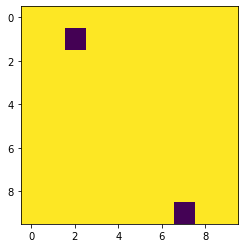

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 13.2     |
|    ep_rew_mean        | -87.8    |
| time/                 |          |
|    fps                | 2000     |
|    iterations         | 4600     |
|    time_elapsed       | 11       |
|    total_timesteps    | 23000    |
| train/                |          |
|    entropy_loss       | -6       |
|    explained_variance | 2.38e-07 |
|    learning_rate      | 0.0007   |
|    n_updates          | 4004599  |
|    policy_loss        | 0.182    |
|    value_loss         | 0.00116  |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 13.3     |
|    ep_rew_mean        | -87.7    |
| time/                 |          |
|    fps                | 2004     |
|    iterations         | 4700     |
|    time_elapsed       | 11       |
|    total_timesteps    | 23500    |
| train/                |          |
|

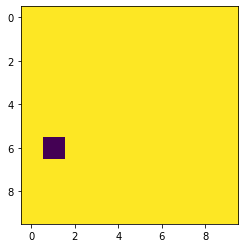

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 12.2     |
|    ep_rew_mean        | -88.8    |
| time/                 |          |
|    fps                | 2005     |
|    iterations         | 4800     |
|    time_elapsed       | 11       |
|    total_timesteps    | 24000    |
| train/                |          |
|    entropy_loss       | -5.31    |
|    explained_variance | 1.19e-07 |
|    learning_rate      | 0.0007   |
|    n_updates          | 4004799  |
|    policy_loss        | 0.166    |
|    value_loss         | 0.00156  |
------------------------------------
-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 11.8      |
|    ep_rew_mean        | -89.2     |
| time/                 |           |
|    fps                | 2004      |
|    iterations         | 4900      |
|    time_elapsed       | 12        |
|    total_timesteps    | 24500     |
| train/                |    

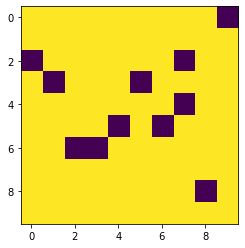

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 11.1     |
|    ep_rew_mean        | -89.9    |
| time/                 |          |
|    fps                | 1998     |
|    iterations         | 5000     |
|    time_elapsed       | 12       |
|    total_timesteps    | 25000    |
| train/                |          |
|    entropy_loss       | -4.62    |
|    explained_variance | 0        |
|    learning_rate      | 0.0007   |
|    n_updates          | 4004999  |
|    policy_loss        | 0.192    |
|    value_loss         | 0.00242  |
------------------------------------
-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 11.2      |
|    ep_rew_mean        | -89.8     |
| time/                 |           |
|    fps                | 1995      |
|    iterations         | 5100      |
|    time_elapsed       | 12        |
|    total_timesteps    | 25500     |
| train/                |    

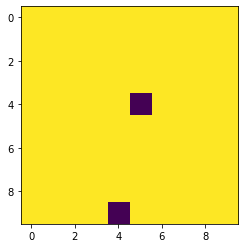

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 12.6     |
|    ep_rew_mean        | -88.4    |
| time/                 |          |
|    fps                | 1995     |
|    iterations         | 5200     |
|    time_elapsed       | 13       |
|    total_timesteps    | 26000    |
| train/                |          |
|    entropy_loss       | -4.81    |
|    explained_variance | 1.19e-07 |
|    learning_rate      | 0.0007   |
|    n_updates          | 4005199  |
|    policy_loss        | 0.117    |
|    value_loss         | 0.000881 |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 13.3     |
|    ep_rew_mean        | -87.7    |
| time/                 |          |
|    fps                | 1996     |
|    iterations         | 5300     |
|    time_elapsed       | 13       |
|    total_timesteps    | 26500    |
| train/                |          |
|

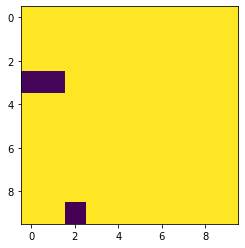

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 13.8     |
|    ep_rew_mean        | -87.2    |
| time/                 |          |
|    fps                | 1992     |
|    iterations         | 5400     |
|    time_elapsed       | 13       |
|    total_timesteps    | 27000    |
| train/                |          |
|    entropy_loss       | -5.78    |
|    explained_variance | 2.98e-07 |
|    learning_rate      | 0.0007   |
|    n_updates          | 4005399  |
|    policy_loss        | 0.166    |
|    value_loss         | 0.00125  |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 12.8     |
|    ep_rew_mean        | -88.2    |
| time/                 |          |
|    fps                | 1987     |
|    iterations         | 5500     |
|    time_elapsed       | 13       |
|    total_timesteps    | 27500    |
| train/                |          |
|

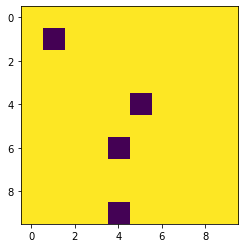

-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 12.1      |
|    ep_rew_mean        | -88.9     |
| time/                 |           |
|    fps                | 1973      |
|    iterations         | 5600      |
|    time_elapsed       | 14        |
|    total_timesteps    | 28000     |
| train/                |           |
|    entropy_loss       | -5.91     |
|    explained_variance | 0         |
|    learning_rate      | 0.0007    |
|    n_updates          | 4005599   |
|    policy_loss        | -1.08e+03 |
|    value_loss         | 3.8e+04   |
-------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 12.4     |
|    ep_rew_mean        | -88.6    |
| time/                 |          |
|    fps                | 1974     |
|    iterations         | 5700     |
|    time_elapsed       | 14       |
|    total_timesteps    | 28500    |
| train/             

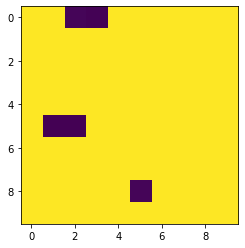

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 11.8     |
|    ep_rew_mean        | -89.2    |
| time/                 |          |
|    fps                | 1969     |
|    iterations         | 5800     |
|    time_elapsed       | 14       |
|    total_timesteps    | 29000    |
| train/                |          |
|    entropy_loss       | -5.8     |
|    explained_variance | 5.96e-08 |
|    learning_rate      | 0.0007   |
|    n_updates          | 4005799  |
|    policy_loss        | -888     |
|    value_loss         | 3.07e+04 |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 12.5     |
|    ep_rew_mean        | -88.5    |
| time/                 |          |
|    fps                | 1962     |
|    iterations         | 5900     |
|    time_elapsed       | 15       |
|    total_timesteps    | 29500    |
| train/                |          |
|

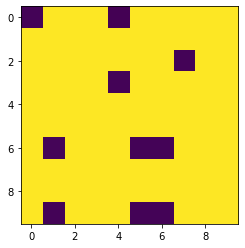

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 12.6     |
|    ep_rew_mean        | -88.4    |
| time/                 |          |
|    fps                | 1956     |
|    iterations         | 6000     |
|    time_elapsed       | 15       |
|    total_timesteps    | 30000    |
| train/                |          |
|    entropy_loss       | -5.55    |
|    explained_variance | 1.19e-07 |
|    learning_rate      | 0.0007   |
|    n_updates          | 4005999  |
|    policy_loss        | 0.181    |
|    value_loss         | 0.00146  |
------------------------------------
-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 13.3      |
|    ep_rew_mean        | -87.7     |
| time/                 |           |
|    fps                | 1957      |
|    iterations         | 6100      |
|    time_elapsed       | 15        |
|    total_timesteps    | 30500     |
| train/                |    

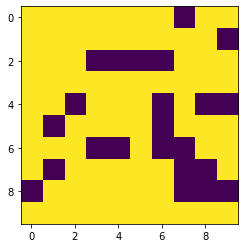

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 13.2     |
|    ep_rew_mean        | -87.8    |
| time/                 |          |
|    fps                | 1955     |
|    iterations         | 6200     |
|    time_elapsed       | 15       |
|    total_timesteps    | 31000    |
| train/                |          |
|    entropy_loss       | -5.04    |
|    explained_variance | 1.19e-07 |
|    learning_rate      | 0.0007   |
|    n_updates          | 4006199  |
|    policy_loss        | 0.13     |
|    value_loss         | 0.000859 |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 12.9     |
|    ep_rew_mean        | -88.1    |
| time/                 |          |
|    fps                | 1952     |
|    iterations         | 6300     |
|    time_elapsed       | 16       |
|    total_timesteps    | 31500    |
| train/                |          |
|

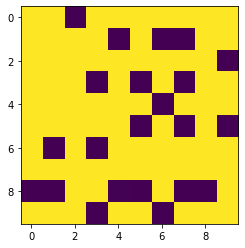

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 12.7     |
|    ep_rew_mean        | -88.3    |
| time/                 |          |
|    fps                | 1954     |
|    iterations         | 6400     |
|    time_elapsed       | 16       |
|    total_timesteps    | 32000    |
| train/                |          |
|    entropy_loss       | -4.78    |
|    explained_variance | 0        |
|    learning_rate      | 0.0007   |
|    n_updates          | 4006399  |
|    policy_loss        | 0.157    |
|    value_loss         | 0.00153  |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 12.8     |
|    ep_rew_mean        | -88.2    |
| time/                 |          |
|    fps                | 1950     |
|    iterations         | 6500     |
|    time_elapsed       | 16       |
|    total_timesteps    | 32500    |
| train/                |          |
|

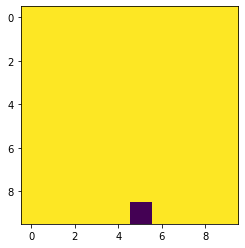

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 12.2     |
|    ep_rew_mean        | -88.8    |
| time/                 |          |
|    fps                | 1952     |
|    iterations         | 6600     |
|    time_elapsed       | 16       |
|    total_timesteps    | 33000    |
| train/                |          |
|    entropy_loss       | -4.79    |
|    explained_variance | 0        |
|    learning_rate      | 0.0007   |
|    n_updates          | 4006599  |
|    policy_loss        | -541     |
|    value_loss         | 2.33e+04 |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 11.9     |
|    ep_rew_mean        | -89.1    |
| time/                 |          |
|    fps                | 1955     |
|    iterations         | 6700     |
|    time_elapsed       | 17       |
|    total_timesteps    | 33500    |
| train/                |          |
|

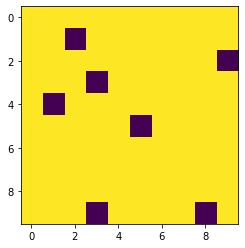

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 12.2     |
|    ep_rew_mean        | -88.8    |
| time/                 |          |
|    fps                | 1947     |
|    iterations         | 6800     |
|    time_elapsed       | 17       |
|    total_timesteps    | 34000    |
| train/                |          |
|    entropy_loss       | -4.78    |
|    explained_variance | 1.19e-07 |
|    learning_rate      | 0.0007   |
|    n_updates          | 4006799  |
|    policy_loss        | -323     |
|    value_loss         | 1.57e+04 |
------------------------------------
-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 12        |
|    ep_rew_mean        | -89       |
| time/                 |           |
|    fps                | 1944      |
|    iterations         | 6900      |
|    time_elapsed       | 17        |
|    total_timesteps    | 34500     |
| train/                |    

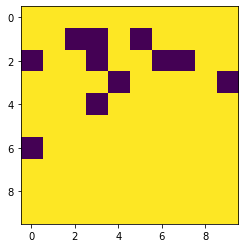

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 11.4     |
|    ep_rew_mean        | -89.6    |
| time/                 |          |
|    fps                | 1943     |
|    iterations         | 7000     |
|    time_elapsed       | 18       |
|    total_timesteps    | 35000    |
| train/                |          |
|    entropy_loss       | -4.9     |
|    explained_variance | 0        |
|    learning_rate      | 0.0007   |
|    n_updates          | 4006999  |
|    policy_loss        | 0.18     |
|    value_loss         | 0.00181  |
------------------------------------
-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 12.3      |
|    ep_rew_mean        | -88.7     |
| time/                 |           |
|    fps                | 1945      |
|    iterations         | 7100      |
|    time_elapsed       | 18        |
|    total_timesteps    | 35500     |
| train/                |    

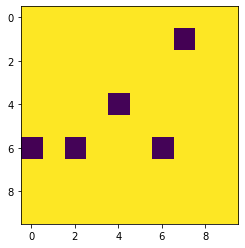

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 12.7     |
|    ep_rew_mean        | -88.3    |
| time/                 |          |
|    fps                | 1946     |
|    iterations         | 7200     |
|    time_elapsed       | 18       |
|    total_timesteps    | 36000    |
| train/                |          |
|    entropy_loss       | -5.32    |
|    explained_variance | 5.96e-08 |
|    learning_rate      | 0.0007   |
|    n_updates          | 4007199  |
|    policy_loss        | -781     |
|    value_loss         | 3.07e+04 |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 12.8     |
|    ep_rew_mean        | -88.2    |
| time/                 |          |
|    fps                | 1949     |
|    iterations         | 7300     |
|    time_elapsed       | 18       |
|    total_timesteps    | 36500    |
| train/                |          |
|

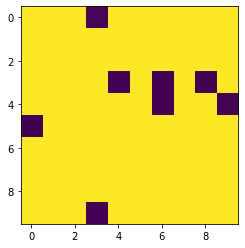

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 12       |
|    ep_rew_mean        | -89      |
| time/                 |          |
|    fps                | 1950     |
|    iterations         | 7400     |
|    time_elapsed       | 18       |
|    total_timesteps    | 37000    |
| train/                |          |
|    entropy_loss       | -5.21    |
|    explained_variance | 0        |
|    learning_rate      | 0.0007   |
|    n_updates          | 4007399  |
|    policy_loss        | -156     |
|    value_loss         | 7.89e+03 |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 11.7     |
|    ep_rew_mean        | -89.3    |
| time/                 |          |
|    fps                | 1953     |
|    iterations         | 7500     |
|    time_elapsed       | 19       |
|    total_timesteps    | 37500    |
| train/                |          |
|

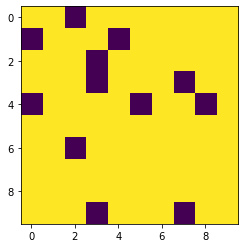

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 11.8     |
|    ep_rew_mean        | -89.2    |
| time/                 |          |
|    fps                | 1950     |
|    iterations         | 7600     |
|    time_elapsed       | 19       |
|    total_timesteps    | 38000    |
| train/                |          |
|    entropy_loss       | -4.92    |
|    explained_variance | 0        |
|    learning_rate      | 0.0007   |
|    n_updates          | 4007599  |
|    policy_loss        | 0.181    |
|    value_loss         | 0.00168  |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 11.5     |
|    ep_rew_mean        | -89.5    |
| time/                 |          |
|    fps                | 1946     |
|    iterations         | 7700     |
|    time_elapsed       | 19       |
|    total_timesteps    | 38500    |
| train/                |          |
|

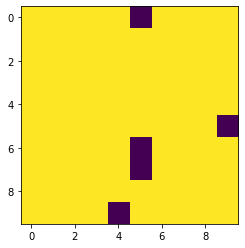

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 11.6     |
|    ep_rew_mean        | -89.4    |
| time/                 |          |
|    fps                | 1947     |
|    iterations         | 7800     |
|    time_elapsed       | 20       |
|    total_timesteps    | 39000    |
| train/                |          |
|    entropy_loss       | -5.39    |
|    explained_variance | 1.79e-07 |
|    learning_rate      | 0.0007   |
|    n_updates          | 4007799  |
|    policy_loss        | -940     |
|    value_loss         | 3.07e+04 |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 11.8     |
|    ep_rew_mean        | -89.2    |
| time/                 |          |
|    fps                | 1950     |
|    iterations         | 7900     |
|    time_elapsed       | 20       |
|    total_timesteps    | 39500    |
| train/                |          |
|

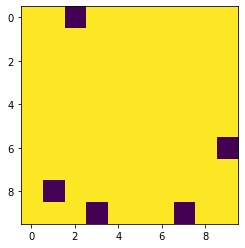

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 11.2     |
|    ep_rew_mean        | -89.8    |
| time/                 |          |
|    fps                | 1952     |
|    iterations         | 8000     |
|    time_elapsed       | 20       |
|    total_timesteps    | 40000    |
| train/                |          |
|    entropy_loss       | -5.18    |
|    explained_variance | 0        |
|    learning_rate      | 0.0007   |
|    n_updates          | 4007999  |
|    policy_loss        | -721     |
|    value_loss         | 3.07e+04 |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 11.8     |
|    ep_rew_mean        | -89.2    |
| time/                 |          |
|    fps                | 1955     |
|    iterations         | 8100     |
|    time_elapsed       | 20       |
|    total_timesteps    | 40500    |
| train/                |          |
|

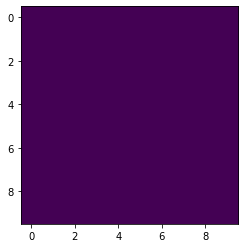

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 12.4     |
|    ep_rew_mean        | -88.6    |
| time/                 |          |
|    fps                | 1956     |
|    iterations         | 8200     |
|    time_elapsed       | 20       |
|    total_timesteps    | 41000    |
| train/                |          |
|    entropy_loss       | -5.48    |
|    explained_variance | 0        |
|    learning_rate      | 0.0007   |
|    n_updates          | 4008199  |
|    policy_loss        | 0.163    |
|    value_loss         | 0.00113  |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 12.6     |
|    ep_rew_mean        | -88.4    |
| time/                 |          |
|    fps                | 1959     |
|    iterations         | 8300     |
|    time_elapsed       | 21       |
|    total_timesteps    | 41500    |
| train/                |          |
|

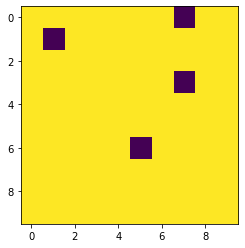

-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 12.3      |
|    ep_rew_mean        | -88.7     |
| time/                 |           |
|    fps                | 1961      |
|    iterations         | 8400      |
|    time_elapsed       | 21        |
|    total_timesteps    | 42000     |
| train/                |           |
|    entropy_loss       | -5.26     |
|    explained_variance | 0         |
|    learning_rate      | 0.0007    |
|    n_updates          | 4008399   |
|    policy_loss        | -1.05e+03 |
|    value_loss         | 3.8e+04   |
-------------------------------------
-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 12.3      |
|    ep_rew_mean        | -88.7     |
| time/                 |           |
|    fps                | 1964      |
|    iterations         | 8500      |
|    time_elapsed       | 21        |
|    total_timesteps    | 42500     |
| train/    

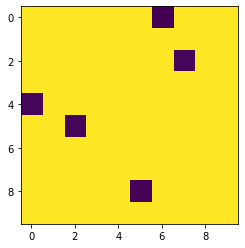

-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 12.6      |
|    ep_rew_mean        | -88.4     |
| time/                 |           |
|    fps                | 1965      |
|    iterations         | 8600      |
|    time_elapsed       | 21        |
|    total_timesteps    | 43000     |
| train/                |           |
|    entropy_loss       | -5.9      |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0007    |
|    n_updates          | 4008599   |
|    policy_loss        | -958      |
|    value_loss         | 3.07e+04  |
-------------------------------------
-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 12.2      |
|    ep_rew_mean        | -88.8     |
| time/                 |           |
|    fps                | 1968      |
|    iterations         | 8700      |
|    time_elapsed       | 22        |
|    total_timesteps    | 43500     |
| train/    

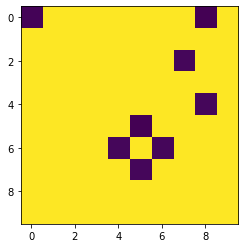

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 11.4     |
|    ep_rew_mean        | -89.6    |
| time/                 |          |
|    fps                | 1966     |
|    iterations         | 8800     |
|    time_elapsed       | 22       |
|    total_timesteps    | 44000    |
| train/                |          |
|    entropy_loss       | -5.59    |
|    explained_variance | 0        |
|    learning_rate      | 0.0007   |
|    n_updates          | 4008799  |
|    policy_loss        | -194     |
|    value_loss         | 7.89e+03 |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 11.9     |
|    ep_rew_mean        | -89.1    |
| time/                 |          |
|    fps                | 1963     |
|    iterations         | 8900     |
|    time_elapsed       | 22       |
|    total_timesteps    | 44500    |
| train/                |          |
|

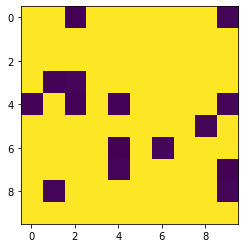

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 12.4     |
|    ep_rew_mean        | -88.6    |
| time/                 |          |
|    fps                | 1959     |
|    iterations         | 9000     |
|    time_elapsed       | 22       |
|    total_timesteps    | 45000    |
| train/                |          |
|    entropy_loss       | -5.95    |
|    explained_variance | 0        |
|    learning_rate      | 0.0007   |
|    n_updates          | 4008999  |
|    policy_loss        | 0.164    |
|    value_loss         | 0.00106  |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 13       |
|    ep_rew_mean        | -88      |
| time/                 |          |
|    fps                | 1956     |
|    iterations         | 9100     |
|    time_elapsed       | 23       |
|    total_timesteps    | 45500    |
| train/                |          |
|

KeyboardInterrupt: 

In [19]:
print_steps = 1_000
n_steps = 20_000_000

# Train the agent for 10000 steps
callback = MyCallBack(log_dir,print_steps)
algo_with_policy.learn(total_timesteps=n_steps,callback=callback)

## Evaluate agent 

In [ ]:
# Evaluate the trained agent
mean_reward, std_reward = evaluate_policy(algo_with_policy, env, n_eval_episodes=100)

print(f"mean_reward:{mean_reward:.2f} +/- {std_reward:.2f}")